In [9]:
import torch as th
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib as mpl
from scipy.stats import circmean
import numpy as np
global DEVICE
DEVICE = 'cuda'
import time
class MCSampler:
    def __init__(self, stds, measurements, n, expl_factor, greedy):
        self.stds = stds.repeat([n,1])
        self.init_stds = self.stds.clone()
        self.measurements = measurements.repeat([n, 1, 1])
        self.n = n
        self.best_guess = None
        self.best_score = 0
        self.expl_factor = expl_factor
        self.greedy = greedy


    def sample_next_states(self, samples, stds):
        result = th.normal(mean=samples, std=stds)
        result[:,-1] = result[:,-1] % np.pi/2
        return result

    def sample_first_state(self):

        f_s = self.sample_current_state(states=th.zeros([self.n, 3], dtype=th.float, device=DEVICE))

        return f_s

    def weighted_avrg_state(self, states, scores):
        circ_w = circ_mean(states[:,-1], scores)
        w_states = states.T * scores
        w_avr = w_states.sum(1)
        w_avr[-1] = circ_w
        return w_avr

    def cal_std_factor(self, scores, df = 0.1):
        assert scores.min() >= 0
        assert scores.max() <= 1
        #return th.exp(th.log(th.tensor(df))*th.sqrt(scores))
        return 1*th.std(scores)

    def sample_current_state(self, states):

        scores, no_matches, counts = self._compute_score(states)
        std_factor = self.cal_std_factor(counts)
        self.std_factor = std_factor
        self.stds = (self.init_stds.T * std_factor).T
        w_avrg = self.weighted_avrg_state(states=states, scores=scores)
        self.w_average = w_avrg
        max_score_index = scores.argsort(dim=0)
        org_states = states.clone()

        if no_matches:
            states = th.zeros([self.n, 3], dtype=th.float, device=DEVICE)

            self.stds = self.init_stds.clone()

            cd = th.distributions.Categorical(probs=scores)
            new_sample_indices = cd.sample(sample_shape=[self.n])
            next_states = self.sample_next_states(states[new_sample_indices], stds=self.expl_factor*self.stds)
        else:
            if not self.greedy:
                cd = th.distributions.Categorical(probs=scores)
                new_sample_indices = cd.sample(sample_shape=[self.n])
            else:
                new_sample_indices = [max_score_index[-1]]*self.n
            self.stds = self.stds[new_sample_indices]
            next_states = self.sample_next_states(states[new_sample_indices], stds=self.stds)
            '''if not self.greedy:
                self.stds = 0.1 * th.std(states[new_sample_indices], dim=0)'''
        keep_n_best = int(self.measurements.size(1)/10)
        next_states[:keep_n_best] = org_states[max_score_index[:keep_n_best]]
        next_states[keep_n_best] = w_avrg
        return next_states

    def _compute_score(self, samples):
        check_points = back_transform_points(self.measurements, samples)
        point_scores = points_in_rectangle(check_points)
        scores = point_scores.type(th.float).mean([1])
        no_matches = False
        if scores.sum() == 0:
            scores = th.rand_like(scores)
            no_matches = True
        else:
            pass
            
            max_obj = scores.max(0)
            if max_obj.values > self.best_score:
                self.best_score = max_obj.values
                self.best_guess = samples[max_obj.indices]
                print(self.best_score)
                scores_args = scores.argsort()[-100:]
                self.samples = samples[scores_args]
                self.point_scores = point_scores[scores_args]
                self.scores = scores[scores_args]
        exp_scores = th.exp(scores) - 1
        exp_scores = exp_scores / exp_scores.sum()
        return exp_scores, no_matches, scores

def transform_points(coordinates, transform_parameters):
    t_c = coordinates.clone()
    t_c[:, :, 0] = (t_c[:, :, 0]) - 0.5
    t_c[:, :, 1] = (t_c[:, :, 1]) - 0.5
    rad_alpha = transform_parameters[:,-1]
    s = th.sin(rad_alpha)
    c = th.cos(rad_alpha)
    rot = th.stack([th.stack([c, -s]),
                    th.stack([s, c])])
    t_c = t_c @ rot.transpose(0,2)
    t_c[:, :, 0] = (t_c[:, :, 0]) + transform_parameters[:, None, 0] + 0.5
    t_c[:, :, 1] = (t_c[:, :, 1]) + transform_parameters[:, None, 1] + 0.5
    return t_c

def back_transform_points(coordinates, transform_parameters):
    t_c = coordinates.clone()
    t_c[:, :, 0] = (t_c[:, :, 0]) - transform_parameters[:, None, 0] - 0.5
    t_c[:, :, 1] = (t_c[:, :, 1]) - transform_parameters[:, None, 1] - 0.5

    rad_alpha = -transform_parameters[:, -1]
    s = th.sin(rad_alpha)
    c = th.cos(rad_alpha)
    rot = th.stack([th.stack([c, -s]),
                    th.stack([s, c])])
    t_c = t_c @ rot.transpose(0, 2)

    t_c[:, :, 0] = (t_c[:, :, 0]) + 0.5
    t_c[:, :, 1] = (t_c[:, :, 1]) + 0.5
    return t_c

def draw_rectangle_points(t_coordinates, ax):
    t_coordinates = t_coordinates.T.numpy()
    ax.scatter(t_coordinates[0], t_coordinates[1])
    plt.show()

def points_in_rectangle(coordinates):
    max_mask = coordinates >= 0
    min_mask = coordinates <= 1
    mask = max_mask * min_mask
    mask = mask[:,:,0] * mask[:,:,1]
    return mask

def draw_recangle(ax, transform_parameters, color):
    width = 1
    height =1
    x = transform_parameters[0].cpu()
    y = transform_parameters[1].cpu()
    alpha = transform_parameters[2]

    rectangle = patches.Rectangle((-0.5, -0.5), width, height, color=color, alpha=0.50)

    t1 = mpl.transforms.Affine2D().translate(x + 0.5 , y + 0.5)
    r1 = mpl.transforms.Affine2D().rotate_deg(th.rad2deg(alpha))
    rectangle.set_transform(r1 + t1 + ax.transData)

    ax.add_patch(rectangle)

    min_x = min(x - 4, -10)
    max_x = max(x + 4, 10)
    min_y = min(y - 4, -10)
    max_y = max(y + 4, 10)


    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)

    plt.grid(True)

    return ax

def draw_points(ax, points, scores):
    points = points.to('cpu')
    scores=scores.to('cpu')
    ax.plot(points[:,0][scores], points[:,1][scores], marker='o', linestyle='', markersize=2, label='hit')
    ax.plot(points[:,0][~scores], points[:,1][~scores], marker='o', linestyle='', markersize=2, label='miss')
    return ax

def circ_mean(inpt, scores):
    norm_inpt = inpt * 4
    sin_i = th.sin(norm_inpt)
    cos_i = th.cos(norm_inpt)
    sin_sum = (sin_i * scores).sum()
    cos_sum = (cos_i * scores).sum()
    result = ((th.atan2(sin_sum, cos_sum)/4) % (np.pi/4))
    return result



tensor(0.3491)
____________
tensor(0.0220, device='cuda:0')
tensor(0.0398, device='cuda:0')
tensor(0.0650, device='cuda:0')
tensor(0.0750, device='cuda:0')
tensor(0.0822, device='cuda:0')
tensor(0.0932, device='cuda:0')
tensor(0.1022, device='cuda:0')
tensor(0.1140, device='cuda:0')
tensor(0.1288, device='cuda:0')
tensor(0.1388, device='cuda:0')
tensor(0.1686, device='cuda:0')
tensor(0.1928, device='cuda:0')
tensor(0.2204, device='cuda:0')
tensor(0.2680, device='cuda:0')
tensor(0.2932, device='cuda:0')
tensor(0.3510, device='cuda:0')
tensor(0.4336, device='cuda:0')
tensor(0.5512, device='cuda:0')
tensor(0.6432, device='cuda:0')
tensor(0.8328, device='cuda:0')
tensor(0.9312, device='cuda:0')
tensor(0.9802, device='cuda:0')
tensor(0.9874, device='cuda:0')
tensor(0.9928, device='cuda:0')
tensor(0.9940, device='cuda:0')
tensor(0.9972, device='cuda:0')
time passed: 12.469897879997006
computed result: tensor([-9.9988, 29.9996,  0.3425], device='cuda:0')
expected result: tensor([[-10.0000,  3

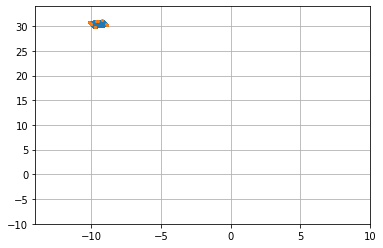

In [10]:
num_measurements = 5000  #Anzahl der positiven Messpunkte
x = -10            #Gesuchter x-Wert
y = 30                 #Gesuchter y-Wert
alpha = th.deg2rad(th.tensor(20))             #Gesuchter Winkel
stds = th.tensor([1, 1, 1], device=DEVICE)   #Standard Abweichungen [x, y, alpha]. Wird von Gauß gesampelt
n = 30000                          #Anzahl an Hypothesen pro Iteration
num_iterations = 60                #Maximale Anzahl Iterationen
expl_factor = 100                   #Wenn noch keine Hypothese mit mindestens einer gültigen Lösung gefunden wurde, werden die stds multipliziert, um das Erkunden zu beschleunigen
greedy = False                       #Wenn wahr verhält sich der alg. wie ein Bergesteiger alg. =)

print(alpha)
print('____________')
#das sind erstmal alle Parameter
measurements = th.rand([1, num_measurements, 2], device=DEVICE)
real_transform_parameters = th.tensor([[x,y,alpha]], device=DEVICE)
measurements = transform_points(measurements, real_transform_parameters)
mcs = MCSampler(stds=stds, measurements=measurements, n=n, expl_factor=expl_factor, greedy=greedy)
next_samples = mcs.sample_first_state()
i = 0

h = time.perf_counter()
while i < num_iterations and (mcs.best_score < measurements.size(1)):
    next_samples = mcs.sample_current_state(states=next_samples)
    i += 1
print(f'time passed: {time.perf_counter() - h}')
print(f'computed result: {mcs.best_guess}')
print(f'expected result: {real_transform_parameters}')
print(f'rel number of successfully fitted measurements: {mcs.best_score}')
fig = plt.figure()
ax = fig.add_subplot(111)
ax = draw_recangle(ax, real_transform_parameters[0], color='blue')
ax = draw_recangle(ax, mcs.best_guess, color='red')
#for tf_para in th.flip(mcs.samples[mcs.samples[:,-1]<0.3][-10:], dims=[0]):
for tf_para in th.flip(mcs.samples[-10:], dims=[0]):
    ax = draw_recangle(ax, tf_para, color='yellow')

mcs.best_guess[-1] = th.deg2rad(th.tensor([90]))
ax = draw_points(ax=ax, points=measurements[0], scores=mcs.point_scores[-1])
plt.show()